**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

----

In [1]:
# # показывать выдачу всех строк ячейки
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import numpy.random as rng
# import pandas as pd

# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

## генерируем датасет

In [3]:
# # from sklearn.datasets import fetch_california_housing
# # from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# X,target = make_blobs( n_samples=1_000, centers=2, cluster_std=[1.7,1.8] )
X,target = make_regression(n_samples=1_000,n_features=1,noise=9.1, shuffle=True,)
print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(1000, 1) (1000,)


In [4]:
# преобразуем список меток к размерности выхода модели
y_train = target_train[:,np.newaxis]
y_val = target_val[:,np.newaxis]
y_test = target_test[:,np.newaxis]
y_train.shape,y_val.shape,y_test.shape

((448, 1), (222, 1), (330, 1))

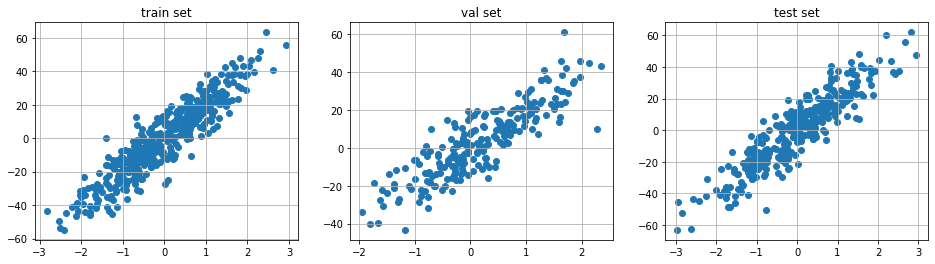

In [5]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train,y_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val,y_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test,y_test)
ax2.set_title('test set')
ax2.grid()

## LinearRegression + MSQE + SGD

In [6]:
from lib.initiator.linear import UniformInitiatorLinearModel

from lib.model.linear import LinearRegression
model = LinearRegression(
    initiator=UniformInitiatorLinearModel(
    # initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
    )
)

model.weight.shape

(1, 1)

In [7]:
from lib.loss.msqe import MSQE
loss = MSQE(model)

from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
lra = ConstLRA(.1)

from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
# SGD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.)
# SGD.fit(data_train,batch_size, data_val=None,n_epoch=2,target_is_indices=False):

In [8]:
model = SGD(
    loss=loss,
    lra=lra,
    #breaker=es,
    #regul=reg,
    #momentum=.01,    
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
    batch_size=y_train.shape[0]//10,
)

100%|██████████| 15/15 [00:00<00:00, 927.63it/s, loss=84, lr=0.1]


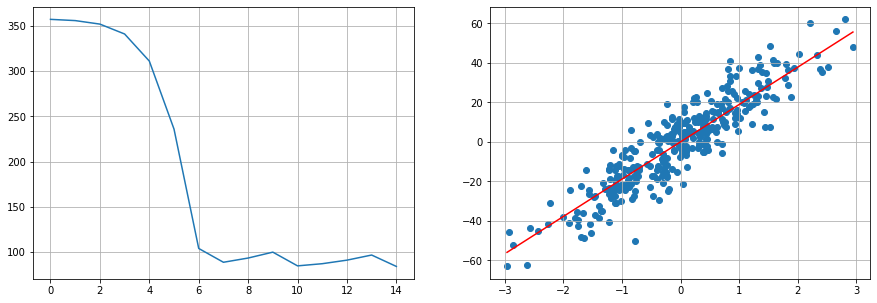

In [9]:
x = np.linspace(X_test.min(),X_test.max(),100)[:,np.newaxis]
p = model.predict(x)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15,5))
ax0.plot(loss.history)
ax0.grid()

ax1.scatter(X_test,y_test)
ax1.plot(x,p,c='r')
ax1.grid()
